In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as LA
import numpy as np

from model import *
from Simulator import *

In [2]:
dataset = DistributionDataset(n_obs='random')
dataloader = DataLoader(dataset, batch_size=1)

In [7]:
summary_net = InvariantNetwork(1)
evidential_net = EvidentialNetwork(65)

In [8]:
sum([p.numel() for p in summary_net.parameters()])

49120

In [9]:
sum([p.numel() for p in evidential_net.parameters()])

41859

In [ ]:
params = torch.load('ckpt.pth')
summary_net.load_state_dict(params['summary_net'])
evidential_net.load_state_dict(params['evidential_net'])

In [10]:
device = 'cuda'
summary_net = summary_net.to(device)
evidential_net = evidential_net.to(device)

In [11]:
epoch = 32
lr = 0.0001
from torch.optim import Adam
optimizer = Adam([
    {'params': summary_net.parameters()},
    {'params': evidential_net.parameters()}
], lr=lr)
lamb = 0.1

In [12]:
rec_loss = []
rec_acc = []
for i_epoch in range(epoch):
    for i ,(m,p,x) in enumerate(dataloader):
        m = m.to(device)
        x = x.to(device)
        
        optimizer.zero_grad()

        alpha = evidential_net(summary_net(x))

        l1 = loss_cls(alpha, m)
        l2 = loss_kl(alpha, m)
        l = l1 + lamb * l2

        l.backward()
        optimizer.step()

        rec_loss.append(l.item())
        rec_acc.append(((alpha.argmax(dim=-1)==m.argmax(dim=-1)).float().sum() / alpha.shape[0]).item())

        # if i % 100 == 99:
        #     print(l.item(), l1.item(), l2.item())

    if 1:
        print(f"epoch {i_epoch}:, {sum(rec_loss) / len(rec_loss): 6.4f}, {sum(rec_acc) / len(rec_acc): 6.4f}")
        rec_loss = []
        torch.save({
            'summary_net': summary_net.state_dict(),
            'evidential_net': evidential_net.state_dict()
            }, 'ckpt.pth')


epoch 0:,  1.0738,  0.3728
epoch 1:,  0.9843,  0.4437
epoch 2:,  0.8619,  0.4988


# visualization

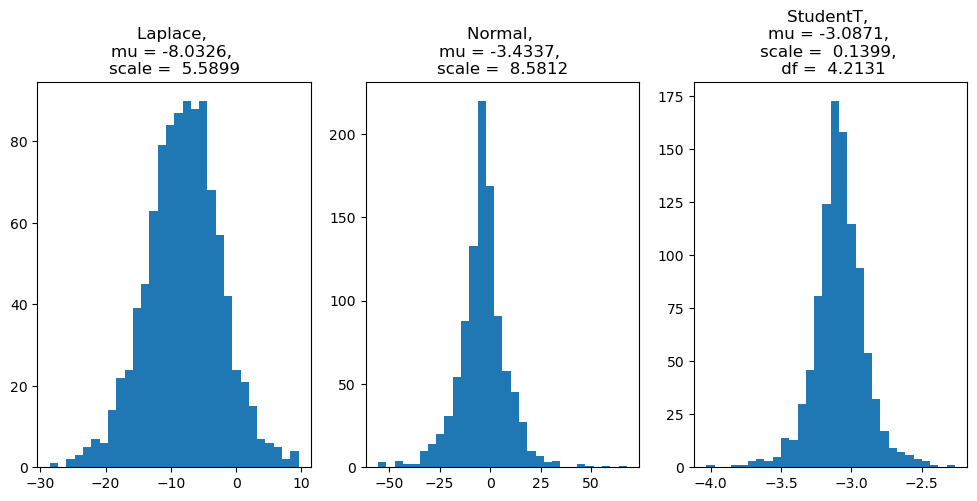

In [31]:
params1, data1 = DistributionDataset.sample_Normal(n_obs=1000)
params2, data2 = DistributionDataset.sample_Laplace(n_obs=1000)
params3, data3 = DistributionDataset.sample_StudentT(n_obs=1000)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3,figsize=(12,5))
axes[0].hist(data1[0], bins=30)
axes[0].set_title(f'Laplace, \nmu = {params1[0,0]: 0.4f}, \nscale = {params1[0,1]: 0.4f}')

axes[1].hist(data2[0], bins=30)
axes[1].set_title(f'Normal, \nmu = {params2[0,0]: 0.4f}, \nscale = {params2[0,1]: 0.4f}')

axes[2].hist(data3[0], bins=30)
axes[2].set_title(f'StudentT, \nmu = {params3[0,0]: 0.4f}, \nscale = {params3[0,1]: 0.4f}, \n df = {params3[0,2]: 0.4f}')
plt.show()


## Normal

### Uncertainty

In [31]:
list_uncertainty = []
for n in range(1,1000):
    params, data = DistributionDataset.sample_Normal(n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_uncertainty.append(pre['uncertainty'].item())

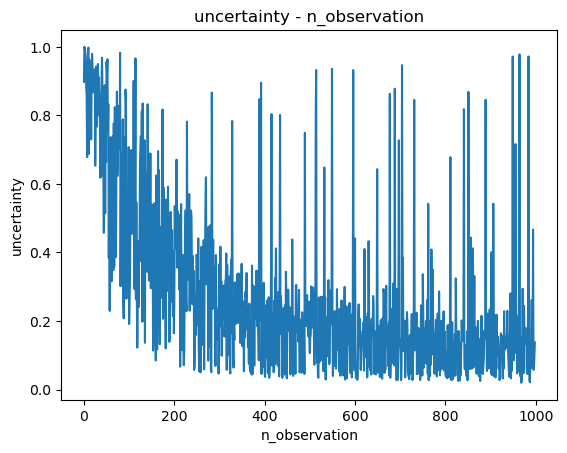

In [15]:
plt.plot(list_uncertainty)
plt.ylabel('uncertainty')
plt.xlabel('n_observation')
plt.title('uncertainty - n_observation')
plt.show()

### Accuracy

In [25]:
list_acc = []
n_nobs = 50
for n in np.arange(1,1000, step=1):
    params, data = DistributionDataset.sample_Normal(n_prior=n_nobs, n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_acc.append((pre['m_probs'].argmax(dim=1)==0).sum().item()/n_nobs)
    # if list_acc[-1]>1.05:
    #     break


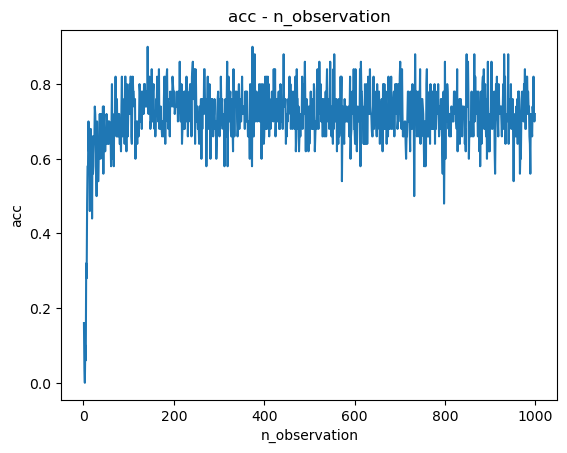

In [27]:
plt.plot(np.arange(1,1000, step=1), list_acc)
plt.ylabel('acc')
plt.xlabel('n_observation')
plt.title('acc - n_observation')
plt.show()

## Laplace

### Uncertainty

In [32]:
list_uncertainty = []
for n in range(1,1000):
    params, data = DistributionDataset.sample_Laplace(n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_uncertainty.append(pre['uncertainty'].item())

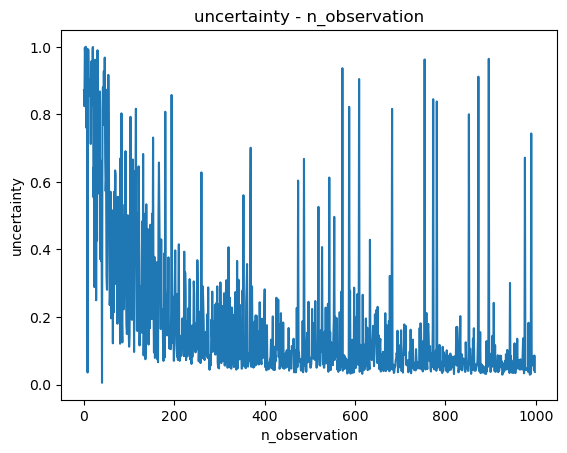

In [33]:
plt.plot(list_uncertainty)
plt.ylabel('uncertainty')
plt.xlabel('n_observation')
plt.title('uncertainty - n_observation')
plt.show()

### Accuracy

In [36]:
list_acc = []
n_nobs = 50
for n in np.arange(1,1000, step=1):
    params, data = DistributionDataset.sample_Laplace(n_prior=n_nobs, n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_acc.append((pre['m_probs'].argmax(dim=1)==1).sum().item()/n_nobs)
    # if list_acc[-1]>1.05:
    #     break


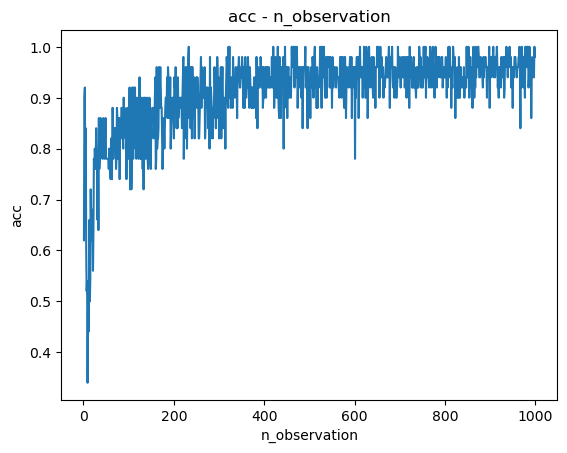

In [37]:
plt.plot(np.arange(1,1000, step=1), list_acc)
plt.ylabel('acc')
plt.xlabel('n_observation')
plt.title('acc - n_observation')
plt.show()

## StudentT

### Uncertainty

In [38]:
list_uncertainty = []
for n in range(1,1000):
    params, data = DistributionDataset.sample_StudentT(n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_uncertainty.append(pre['uncertainty'].item())

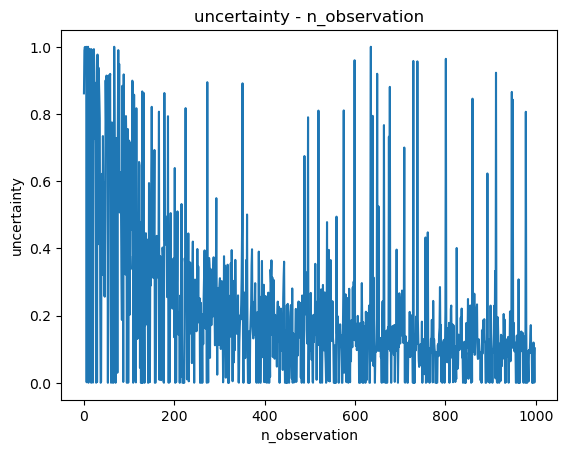

In [39]:
plt.plot(list_uncertainty)
plt.ylabel('uncertainty')
plt.xlabel('n_observation')
plt.title('uncertainty - n_observation')
plt.show()

### Accuracy

In [40]:
list_acc = []
n_nobs = 50
for n in np.arange(1,1000, step=1):
    params, data = DistributionDataset.sample_StudentT(n_prior=n_nobs, n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_acc.append((pre['m_probs'].argmax(dim=1)==2).sum().item()/n_nobs)
    # if list_acc[-1]>1.05:
    #     break


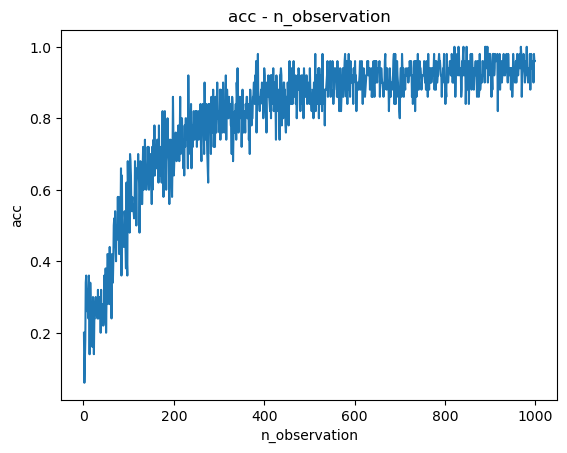

In [41]:
plt.plot(np.arange(1,1000, step=1), list_acc)
plt.ylabel('acc')
plt.xlabel('n_observation')
plt.title('acc - n_observation')
plt.show()